# Гипотеза 3: Существуют лучшие месяцы для релиза, показывающие сезонность интереса

## Смысл:
Мы предпологаем, что у игр есть выраженная сезонность, то есть релизы в некоторые месяца получают заметно больше интереса (оценок/рекомендаций), чем релизы в другие месяцы

Мы проверяем, меняется ли интерес пользователей в зависимости от месяца релиза

Под интересом понимаем:

* **массовость:** ratings_count, reviews_count, suggestions_count, added

* **качество:** взвешенная оценка weighted_rating

Если определённые месяцы стабильно дают выше массовость, их можно считать более удачными для релиза, так как они охватывают большую аудиторию

## Как мы анализируем гипотезу:



Мы будем опираться на очищенный датасет с уже посчитанным столбцом weighted_rating, в нем рассмотрим:

* Время: release_month (1–12)

* Популярность/интерес: ratings_count, suggestions_count, added

* Качество: weighted_rating

* Срез по жанрам: primary_genre/main_genre

**Что хотим построить и зачем:**

* Линейные графики медиан по месяцам для ratings_count, suggestions_count, added — чтобы видеть сезонные пики по интересу

* Скрипичные диаграммы weighted_rating по месяцам — чтобы увидеть форму распределения и медианы

* Боксплоты suggestions_count по месяцам — наглядно сравнить разброс и выбросы

* Теплокарту «месяц × жанр» по медианному weighted_rating — вдруг сезонность зависит от жанра

* Столбчатую диаграмму количества релизов по месяцам — учесть эффект «конкуренции» и плотности релизов.

In [108]:
import os, ast, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns

In [109]:
df = pd.read_csv('dataset_final_cleaned_group_knn_with_weighted.csv')

df.columns = (df.columns.str.strip().str.lower())

## Анализ по визуализациям

### 1. Линейные графики медиан по месяцам для ratings_count, suggestions_count, added

#### Проанализируем насколько реливантно анализировать added, ratings_count, suggestions_count по месяцам

**Зачем это нужно**

Метрики added, ratings_count, suggestions_count — накопительные. Если в каком-то месяце:

- мало наблюдений

- или игры заметно моложе/старше,
то “сезонность” может оказаться артефактом данных, а не реальным эффектом месяца релиза, тк у игр старше есть накопительный эффект по этим метрикам

*Мы проверяем 2 условия:*

- Достаточно и сопоставимо ли количество данных по играм в каждом месяце

- Близок ли возраст игр по месяцам (чтобы накопительный эффект не искажал сравнение)

##### 1. Подготовка данных

In [110]:
df["released_dt"] = pd.to_datetime(df["released"], errors="coerce")
df["updated_dt"]  = pd.to_datetime(df["updated"], errors="coerce")

# корректный месяц из даты
df["release_month_clean"] = df["released_dt"].dt.month

# считаем возраст
snapshot_date = df["updated_dt"].max()
df["age_days"] = (snapshot_date - df["released_dt"]).dt.days

# оставляем только корректные записи
df = df[df["release_month_clean"].between(1, 12)].copy()
df = df[df["age_days"].notna() & (df["age_days"] > 0)].copy()
df["age_days"] = df["age_days"].clip(lower=1)

months = list(range(1, 13))

#####2. Количество данных (n) по каждому месяцу

In [111]:
month_stats = (df.groupby("release_month_clean").agg(n=("name", "size"),
                      med_added=("added", "median"),
                      med_ratings=("ratings_count", "median"),
                      med_sugg=("suggestions_count", "median"))
                 .reset_index()
                 .sort_values("release_month_clean"))

print(month_stats)

    release_month_clean    n  med_added  med_ratings  med_sugg
0                     1  170      314.0         24.0     338.0
1                     2  177      365.0         31.0     348.0
2                     3  194      330.0         27.0     337.0
3                     4  206      369.5         28.0     376.5
4                     5  177      354.0         24.0     342.0
5                     6  159      370.0         27.0     351.0
6                     7  174      361.0         26.5     351.0
7                     8  234      443.0         27.5     331.5
8                     9  235      337.0         28.0     336.0
9                    10  248      329.0         24.0     358.5
10                   11  278      195.0         11.5     284.5
11                   12  163      450.0         34.0     359.0


Визуализация: столбчатая диаграмма количества игр по месяцам

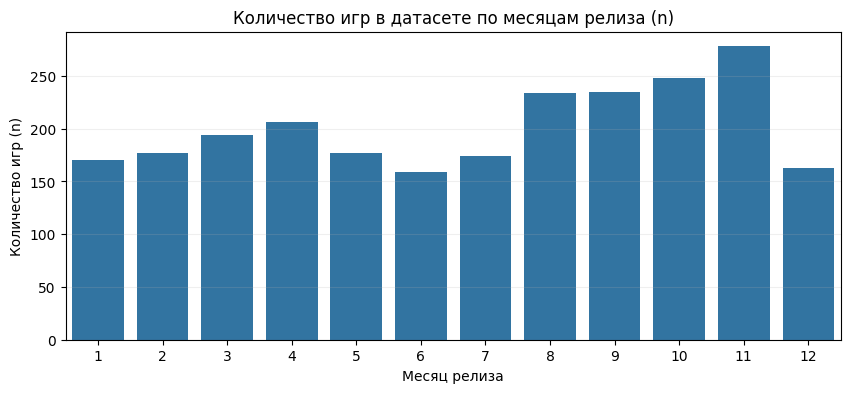

In [112]:
plt.figure(figsize=(10,4))
sns.barplot(data=month_stats, x="release_month_clean", y="n", order=months)
plt.title("Количество игр в датасете по месяцам релиза (n)")
plt.xlabel("Месяц релиза")
plt.ylabel("Количество игр (n)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

**Вывод:**

Мы проверили, насколько равномерно представлены игры по месяцам релиза, чтобы исключить ситуацию, когда выводы о “сезонности” искажаются из-за малого числа наблюдений

По таблице и графику видно, что в каждом месяце имеется достаточно игр: значения n лежат примерно в диапазоне от 156 до 273. То есть нет месяцев с критически малым количеством наблюдений, которые могли бы сделать медианные значения added, ratings_count и suggestions_count случайными и нестабильными

При этом распределение не идеально равномерное: больше всего игр приходится на август–ноябрь, а меньше — на июнь и декабрь. Однако даже в минимальных месяцах объём данных остаётся достаточным для расчёта устойчивых агрегатов

**Промежуточный итог:** по критерию размера выборки анализ сезонности по месяцам для метрик added, ratings_count, suggestions_count в целом корректен (нет сильного перекоса из-за малого n)

##### 3. Средний и медианный возраст игр по месяцам

In [113]:
age_by_month = (df.groupby("release_month_clean")["age_days"].agg(n="size", median_age="median", mean_age="mean")
                  .reset_index()
                  .sort_values("release_month_clean"))

print(age_by_month)

    release_month_clean    n  median_age     mean_age
0                     1  170      3206.0  3925.976471
1                     2  177      2840.0  3194.429379
2                     3  194      3147.5  3174.211340
3                     4  206      3120.5  3257.689320
4                     5  177      3099.0  3500.531073
5                     6  159      3077.0  3554.169811
6                     7  174      2856.5  3294.086207
7                     8  234      3016.0  3247.243590
8                     9  235      2620.0  3242.923404
9                    10  248      2949.5  3461.754032
10                   11  278      1823.5  2424.205036
11                   12  163      3254.0  4056.061350


Визуализация 1: boxplot возраста

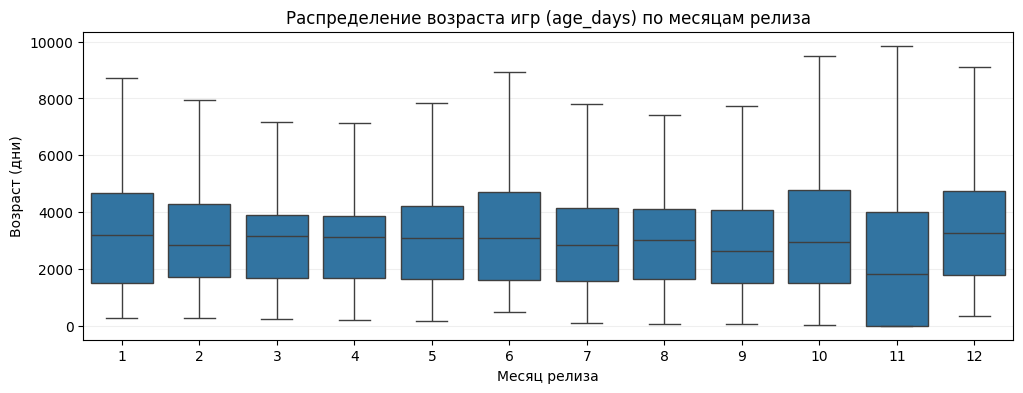

In [114]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="release_month_clean", y="age_days", order=months, showfliers=False)
plt.title("Распределение возраста игр (age_days) по месяцам релиза")
plt.xlabel("Месяц релиза")
plt.ylabel("Возраст (дни)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

Визуализация 2: скрипичная диаграмма

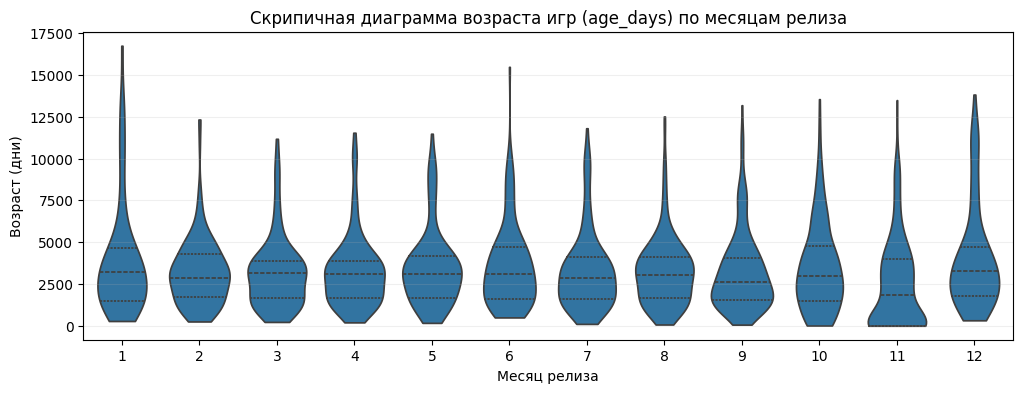

In [115]:
plt.figure(figsize=(12,4))
sns.violinplot(data=df, x="release_month_clean", y="age_days", cut=0, inner="quartile")
plt.title("Скрипичная диаграмма возраста игр (age_days) по месяцам релиза")
plt.xlabel("Месяц релиза")
plt.ylabel("Возраст (дни)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

Мы проверили второе важное условие корректности сезонного анализа: сопоставим ли возраст игр (последние обновление игры - релиз) в разных месяцах, потому что added, ratings_count, suggestions_count — метрики накопительные и естественно растут с возрастом

По таблице age_by_month видно, что для большинства месяцев медианный возраст находится примерно в одном диапазоне (около 3000 дней), а распределения на boxplot/violin в целом похожи: медианы и расспределения расположены близко друг к другу. Это значит, что в целом нет сильного перекоса, который полностью делал бы сравнение месяцев некорректным

**Однако заметно исключение — 11-й месяц:**

- медианный возраст в ноябре существенно ниже (примерно 1832 дней),

- и на графиках видно, что распределение в 11 месяце смещено к меньшим значениям (те больше молодых игр)


###### Чтобы сезонность была честной, дополнительно проанализируем нормированные метрики added_per_day, ratings_per_day, suggestions_per_day

Подготовка данных

In [116]:
# нормированные метрики
df["added_per_day"] = df["added"] / df["age_days"]
df["ratings_per_day"] = df["ratings_count"] / df["age_days"]
df["suggestions_per_day"] = df["suggestions_count"] / df["age_days"]

# для визуализации (чтобы хиты не забивали)
df["log_added"] = np.log1p(df["added"])
df["log_ratings"] = np.log1p(df["ratings_count"])
df["log_sugg"] = np.log1p(df["suggestions_count"])

df["log_added_pd"] = np.log1p(df["added_per_day"])
df["log_ratings_pd"] = np.log1p(df["ratings_per_day"])
df["log_sugg_pd"] = np.log1p(df["suggestions_per_day"])

months = list(range(1,13))

Нормализованные метрики (*_per_day) показывают не сколько всего накопили, а с какой **средней скоростью** это происходило (например, ratings_per_day = ratings_count / age_days). За счёт этого сравнение месяцев становится честнее: мы сравниваем темп набора популярности, а не сколько успели накопить за годы

In [117]:
perday_month = (df.groupby("release_month_clean").agg(n=("name","size"),
                       med_added=("added","median"),
                       med_added_pd=("added_per_day","median"),
                       med_ratings=("ratings_count","median"),
                       med_ratings_pd=("ratings_per_day","median"),
                       med_sugg=("suggestions_count","median"),
                       med_sugg_pd=("suggestions_per_day","median"))
                  .reset_index().sort_values("release_month_clean"))

print(perday_month)

    release_month_clean    n  med_added  med_added_pd  med_ratings  \
0                     1  170      314.0      0.125297         24.0   
1                     2  177      365.0      0.132583         31.0   
2                     3  194      330.0      0.126299         27.0   
3                     4  206      369.5      0.138169         28.0   
4                     5  177      354.0      0.123221         24.0   
5                     6  159      370.0      0.126750         27.0   
6                     7  174      361.0      0.143017         26.5   
7                     8  234      443.0      0.161285         27.5   
8                     9  235      337.0      0.121951         28.0   
9                    10  248      329.0      0.113718         24.0   
10                   11  278      195.0      0.111683         11.5   
11                   12  163      450.0      0.140673         34.0   

    med_ratings_pd  med_sugg  med_sugg_pd  
0         0.010578     338.0     0.115641  
1

“До/после” — boxplot по месяцам

1. Added

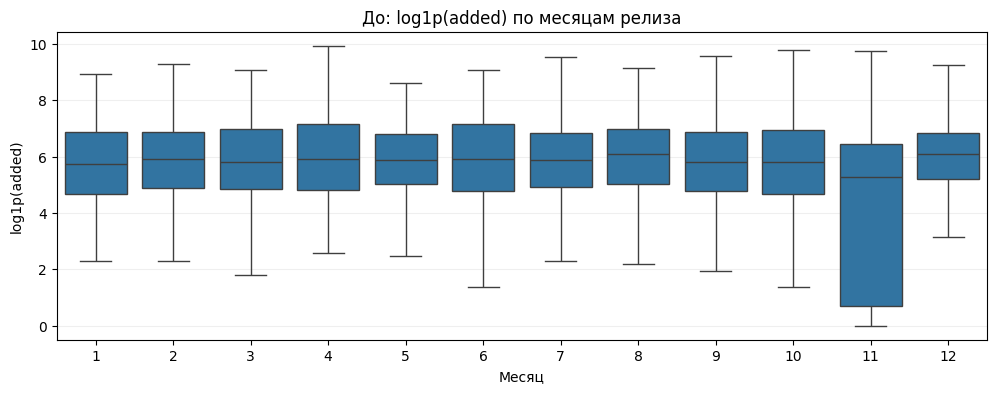

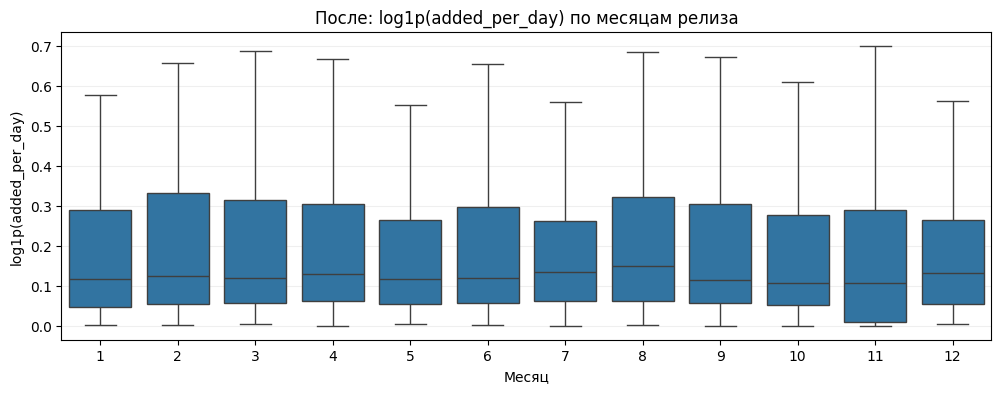

In [118]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="release_month_clean", y="log_added", order=months, showfliers=False)
plt.title("До: log1p(added) по месяцам релиза")
plt.xlabel("Месяц")
plt.ylabel("log1p(added)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="release_month_clean", y="log_added_pd", order=months, showfliers=False)
plt.title("После: log1p(added_per_day) по месяцам релиза")
plt.xlabel("Месяц")
plt.ylabel("log1p(added_per_day)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

2. Ratings

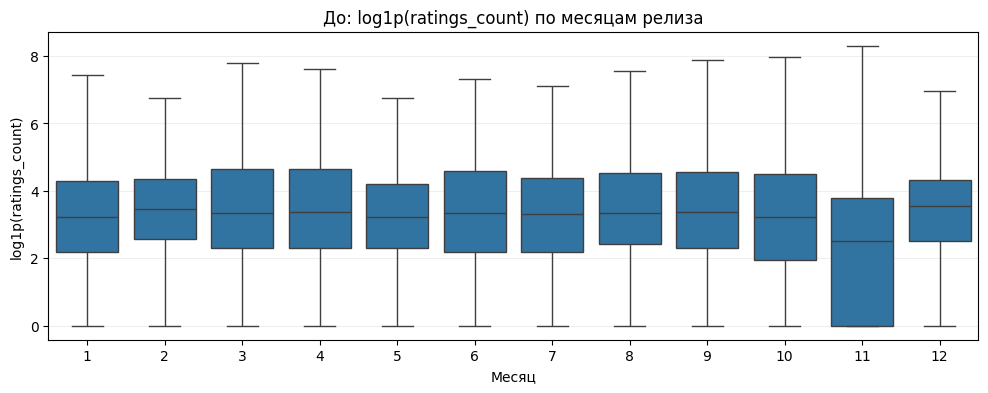

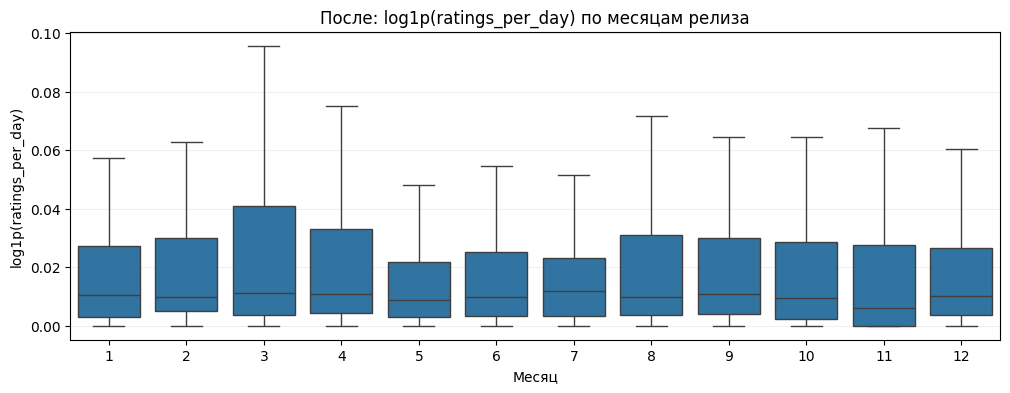

In [119]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="release_month_clean", y="log_ratings", order=months, showfliers=False)
plt.title("До: log1p(ratings_count) по месяцам релиза")
plt.xlabel("Месяц")
plt.ylabel("log1p(ratings_count)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="release_month_clean", y="log_ratings_pd", order=months, showfliers=False)
plt.title("После: log1p(ratings_per_day) по месяцам релиза")
plt.xlabel("Месяц")
plt.ylabel("log1p(ratings_per_day)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

3. Suggestions

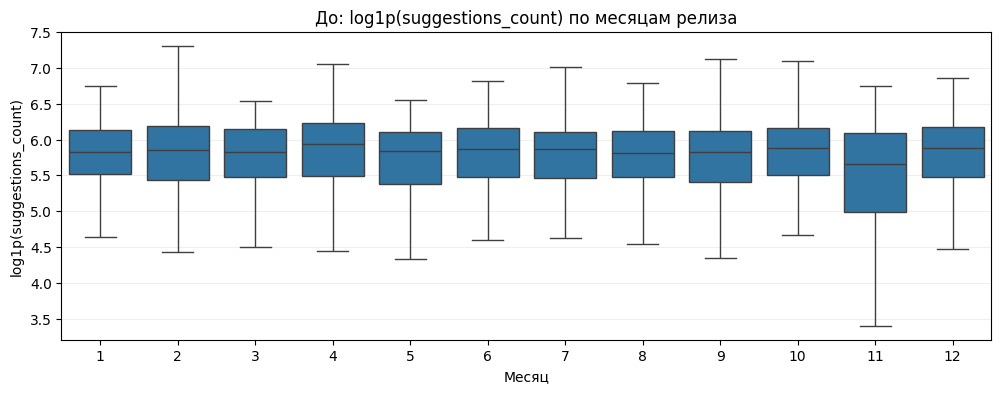

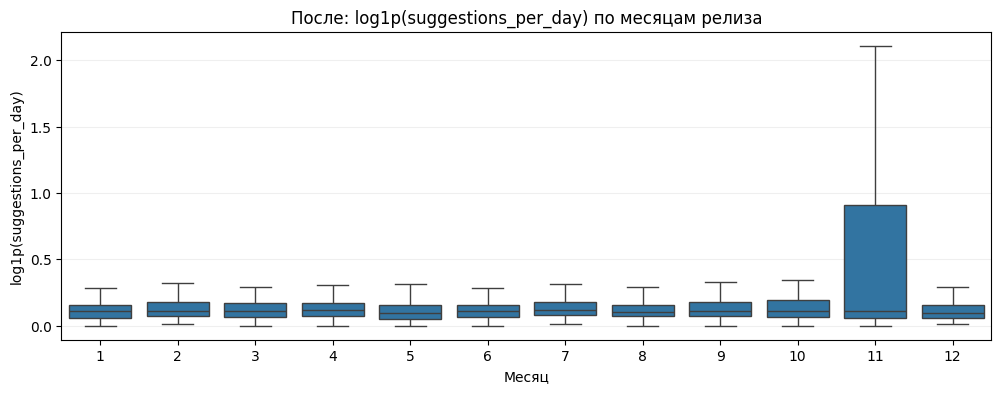

In [120]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="release_month_clean", y="log_sugg", order=months, showfliers=False)
plt.title("До: log1p(suggestions_count) по месяцам релиза")
plt.xlabel("Месяц")
plt.ylabel("log1p(suggestions_count)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(data=df, x="release_month_clean", y="log_sugg_pd", order=months, showfliers=False)
plt.title("После: log1p(suggestions_per_day) по месяцам релиза")
plt.xlabel("Месяц")
plt.ylabel("log1p(suggestions_per_day)")
plt.grid(True, axis="y", alpha=0.2)
plt.show()

После перехода от накопительных метрик (added, ratings_count, suggestions_count) к нормированным (*_per_day) картина по месяцам становится более устойчивой: различия между месяцами сглаживаются, а аномально низкие значения в ноябре заметно уменьшаются. Это подтверждает, что часть сезонного эффекта в исходных графиках была обусловлена накопительным характером метрик и различиями в возрасте игр.
Поэтому для оценки сезонности релизов корректнее опираться на added_per_day, ratings_per_day, suggestions_per_day (либо дополнительно фиксировать возрастной диапазон игр), а накопительные значения использовать только как вспомогательные

#### Анализ сезонности метрик

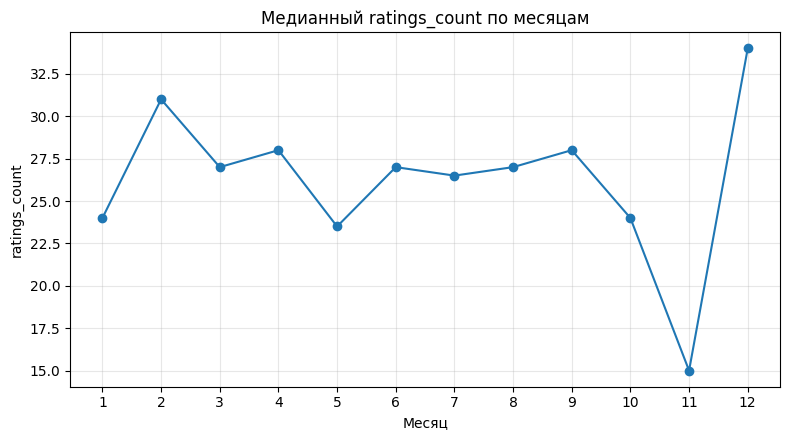

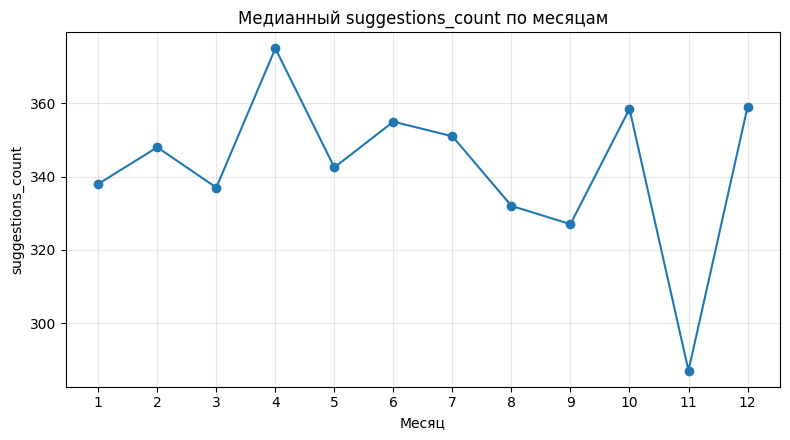

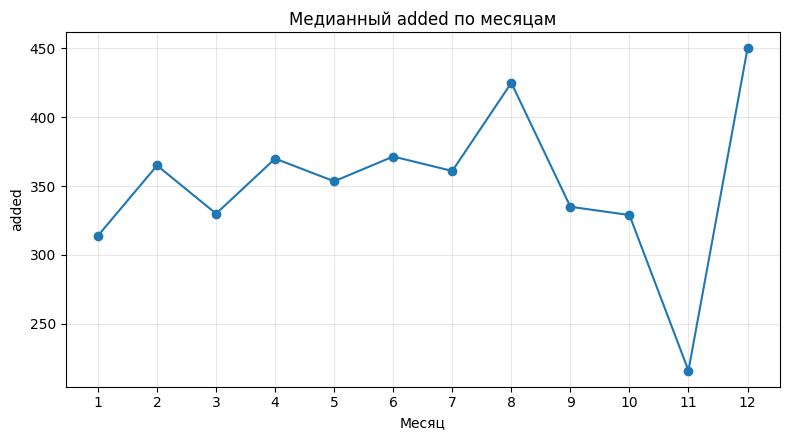

In [121]:
# Медианный ratings_count по месяцам
if "ratings_count" in df.columns:
    med_rc = (df.groupby("release_month")["ratings_count"].median().reindex(months))
    plt.figure(figsize=(8,4.5))
    plt.plot(med_rc.index, med_rc.values, marker="o")
    plt.title("Медианный ratings_count по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("ratings_count")
    plt.xticks(months)
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

# Медианный suggestions_count по месяцам
if "suggestions_count" in df.columns:
    med_sc = (df.groupby("release_month")["suggestions_count"].median().reindex(months))
    plt.figure(figsize=(8,4.5))
    plt.plot(med_sc.index, med_sc.values, marker="o")
    plt.title("Медианный suggestions_count по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("suggestions_count")
    plt.xticks(months)
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

# Медианный added по месяцам
if "added" in df.columns:
    med_added = (df.groupby("release_month")["added"].median().reindex(months))
    plt.figure(figsize=(8,4.5))
    plt.plot(med_added.index, med_added.values, marker="o")
    plt.title("Медианный added по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("added")
    plt.xticks(months)
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

На этих графиках видно по “сильным скачкам” и особенно по резкому провалу в 11 месяце и росту в 12-м — такие эффекты могут возникать не из-за реальной сезонности, а из-за того, что в одном месяце в выборке оказалось больше “молодых” игр, а в другом — больше “старых”

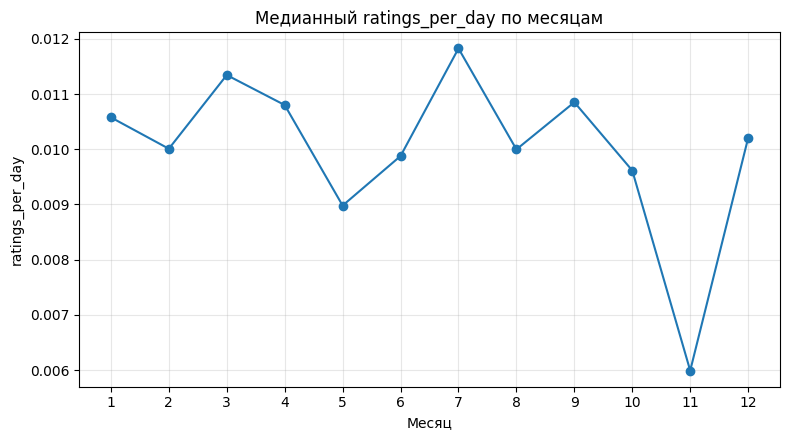

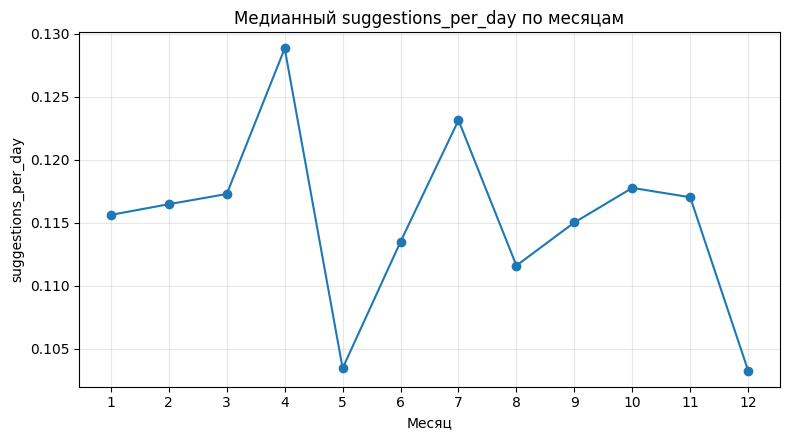

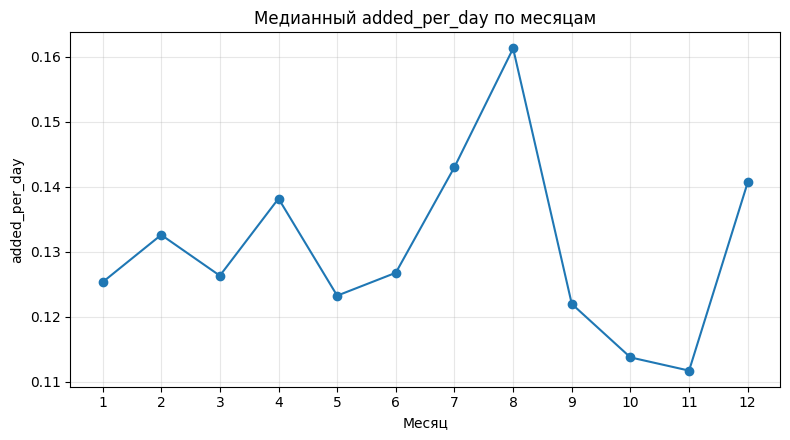

In [122]:
# Медианный ratings_per_day по месяцам
if "ratings_per_day" in df.columns:
    med_rpd = (df.groupby("release_month_clean")["ratings_per_day"].median().reindex(months))
    plt.figure(figsize=(8,4.5))
    plt.plot(med_rpd.index, med_rpd.values, marker="o")
    plt.title("Медианный ratings_per_day по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("ratings_per_day")
    plt.xticks(months)
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

# Медианный suggestions_per_day по месяцам
if "suggestions_per_day" in df.columns:
    med_spd = (df.groupby("release_month_clean")["suggestions_per_day"].median().reindex(months))
    plt.figure(figsize=(8,4.5))
    plt.plot(med_spd.index, med_spd.values, marker="o")
    plt.title("Медианный suggestions_per_day по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("suggestions_per_day")
    plt.xticks(months)
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

# Медианный added_per_day по месяцам
if "added_per_day" in df.columns:
    med_apd = (df.groupby("release_month_clean")["added_per_day"].median().reindex(months))
    plt.figure(figsize=(8,4.5))
    plt.plot(med_apd.index, med_apd.values, marker="o")
    plt.title("Медианный added_per_day по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("added_per_day")
    plt.xticks(months)
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

На графиках мы видим, что *_per_day картина становится более сглаженной и стабильной, а выводы перестают зависеть от того, насколько старые игры попали в конкретный месяц

**Что корректнее анализировать для сезонности**

Так как наша цель понять сезонность успешности релиза (в какой месяц релизу проще/сложнее набрать популярность), то более корректно использовать нормализованные метрики *_per_day (и лучше ещё в log1p, если распределение слишком перекошено)

Накопительные метрики можно использовать как вспомогательные, но делать вывод о сезонности только по ним рискованно, потому что они смешивают:

- эффект месяца релиза

- эффект возраста (накопления)

- и эффект состава игр (жанры/размер/паблишер)

**Вывод по анализу сезонности**

1. В накопительных метриках наблюдались резкие “аномалии” (например, заметный провал в ноябре), но после перехода к *_per_day видно, что значительная часть этих различий — следствие накопительного эффекта и различий в возрасте игр, а не чистой сезонности

2. По нормализованным метрикам сезонный эффект выглядит умереннее:
нет ощущения, что один месяц катастрофически плохой, а другой идеальный — скорее есть месяцы с чуть более высоким/низким темпом набора популярности

- В обоих анализа по **количеству добавленных игр** лидирует - 8 месяц, но также неплохие результаты, выделяющиеся среди других месяцев, показывают 2 и 4 месяцы

- Если говорить об сезонности роста отзывов на игры по месяцам, то по анализу можно заметить, что в обоих случаях прослеживается *бОльший интерес* в особенности в 4 месяц, а также в 10 и 7, а *спад интереса* к 9, 8 и 5 месяцу

- По рейтингу, наиболее перспективными месяцами являются в обоих случаях 3, 4, 9, а спад интереса приходится в 5 и 10 месяцы, а в 11 месяц критически низкое количество оценок получают пользователи

**Практический вывод:**

1. Для планирования релиза ориентируемся в первую очередь на нормализованные метрики (*_per_day), потому что они лучше отражают темп набора популярности и меньше искажены возрастом игры. Накопительные метрики используем как вторичную проверку

2. Если цель — **максимально быстро получить охваты/интерес аудитории** ( added), то наиболее перспективный месяц релиза — *август* (8). Дополнительно хорошими вариантами выглядят *февраль* (2) и *апрель* (4) — они стабильно выше среднего и в накопительных, и в нормализованных метриках

3. Если цель — **быстрее собрать обсуждение/обратную связь** (suggestions), то сильнее всего интерес выражен в *апреле* (4), а также неплохо выглядят *июль* (7) и *октябрь* (10). Более слабые месяцы по динамике отзывов — *май* (5), *август* (8) и *сентябрь* (9), где темп роста интереса ниже

4. По **рейтинговой активности** (ratings_count) наиболее перспективными выглядят *март* (3), *апрель* (4) и *сентябрь* (9). Слабее — *май* (5) и *октябрь* (10).

В целом, хорошим месяцем для впуска является апрель (4), так как он у нас по всем параметрам держиться на хорошем уровне и может принести игре больший интерес

---


Ноябрь (11) в данных выглядит проблемным по количеству оценок (критически низко), поэтому выпуск в ноябре стоит сопровождать усиленной стратегией по привлечению первых пользователей и мотивации оставлять оценки (скидки на запуске, демо/пролог, активный менеджмент, стримеры).

### 2. Скрипичные диаграммы weighted_rating по месяцам
### +
### Боксплоты suggestions_count по месяцам

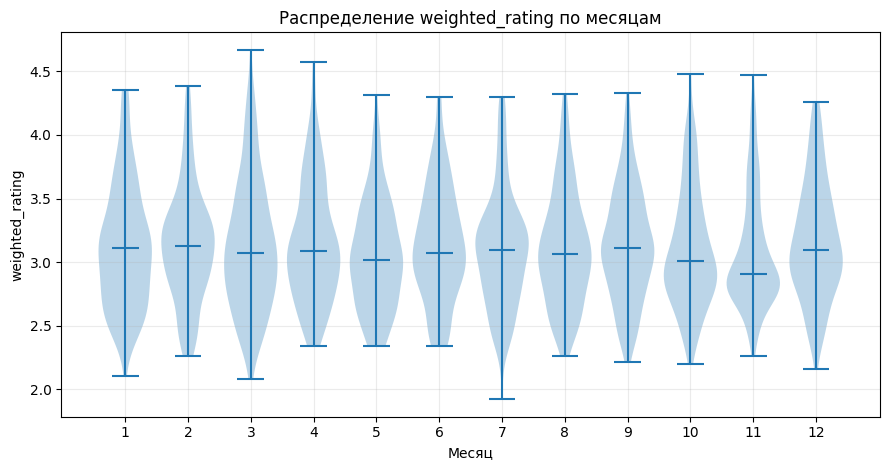

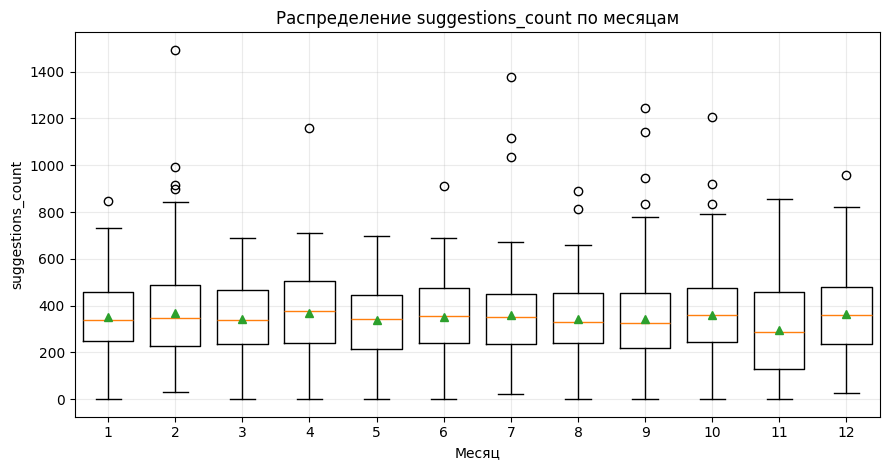

In [123]:
# Violin распределение weighted_rating по месяцам
if "weighted_rating" in df.columns:
    vdata = [df.loc[df["release_month"]==m, "weighted_rating"].values for m in months]
    plt.figure(figsize=(9,4.8))
    plt.violinplot(vdata, positions=months, showmedians=True, widths=.85)
    plt.title("Распределение weighted_rating по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("weighted_rating")
    plt.xticks(months)
    plt.grid(True, alpha=.25)
    plt.tight_layout()
    plt.show()

# Boxplot suggestions_count по месяцам
if "suggestions_count" in df.columns:
    bdata = [df.loc[df["release_month"]==m, "suggestions_count"].values for m in months]
    plt.figure(figsize=(9,4.8))
    plt.boxplot(bdata, positions=months, showmeans=True, widths=.75)
    plt.title("Распределение suggestions_count по месяцам")
    plt.xlabel("Месяц")
    plt.ylabel("suggestions_count")
    plt.xticks(months)
    plt.grid(True, alpha=.25)
    plt.tight_layout()
    plt.show()

**Вывод**

- weighted_rating (скрипичная диаграмма)

Формы распределений очень похожи от месяца к месяцу. Медианы и квартильные линии держатся примерно на одном уровне. Это важный сигнал, что качество по месяцу релиза почти не меняется — сезонность слабая именно для рейтинга

- suggestions_count (боксплоты)

Распределения по месяцам близки, но хвосты (топ-игры) чаще видны в весенне-летние и осенние месяцы. То есть "вирусные" всплески интереса встречаются круглый год, но чуть чаще — с апреля по июнь и с сентября по декабрь

### 3. Столбчатую диаграмму количества релизов по месяцам

Мы хотим построить такой график, чтоб изучить конкуренцию в разные месяцы

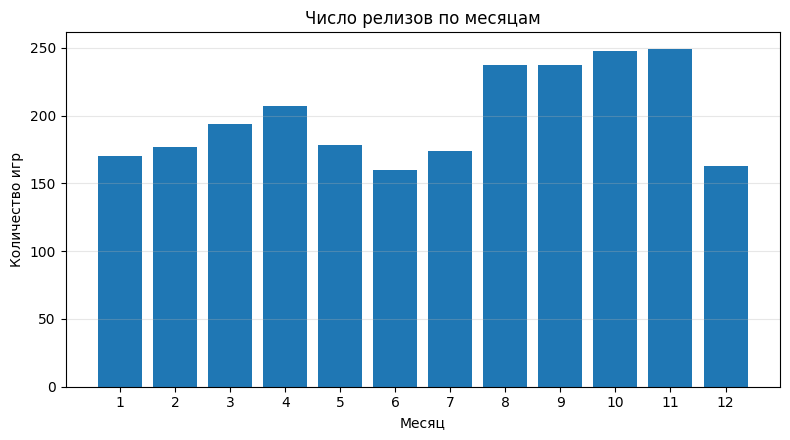

In [124]:
cnt = df["release_month"].value_counts().reindex(months).fillna(0)
plt.figure(figsize=(8,4.5))
plt.bar(months, cnt.values)
plt.title("Число релизов по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество игр")
plt.xticks(months)
plt.grid(True, axis="y", alpha=.3)
plt.tight_layout()
plt.show()

По столбчатой диаграмме видно, что распределение релизов по месяцам неравномерное. Максимальная плотность релизов приходится на конец лета и осень — особенно август–ноябрь (8–11): в эти месяцы выходит больше всего игр, то есть конкуренция за внимание игроков наиболее высокая

Более спокойные месяцы по количеству релизов — июнь–июль (6–7) и декабрь (12) (а также начало года выглядит умеренно). Это означает, что в эти периоды потенциально ниже конкурентная нагрузка, и игре может быть проще выделиться в витринах и новостных лентах

**Практический смысл:** если цель — меньше конкурировать, имеет смысл рассматривать релиз вне пикового периода (8–11). Если же релиз планируется на осень, то важно закладывать более сильную маркетинговую поддержку, потому что шум и конкуренция в это время выше

### 4. Теплокарта «месяц × жанр» по медианному weighted_rating




Перед тем как это анализировать, необходимо убедиться сколько у нас существует в принципе пересечений месяц × жанр, чтоб у нас были достоверный анализ, тк

Heatmap с медианой метрики по ячейкам (жанр, месяц) может выглядит убедительно, но: если в ячейке мало игр (например 1–5), медиана становится случайной (одна “залетевшая” игра делает ячейку “суперуспешной”), можно сделать вывод “в этом месяце жанр X лучше”, хотя это просто шум маленькой выборк

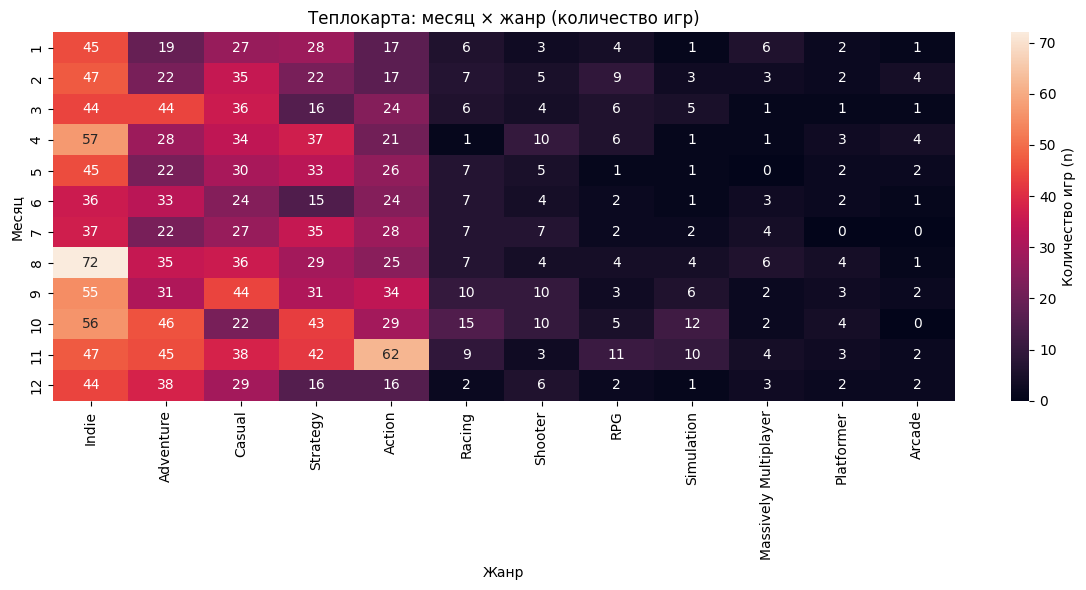

In [125]:
top_genres = df["main_genre"].astype(str).value_counts().head(12).index

cnt_pvt = (df[df["main_genre"].astype(str).isin(top_genres)].pivot_table(index="release_month_clean",
                        columns="main_genre",
                        values="name",
                        aggfunc="size",
                        fill_value=0)
           .reindex(index=months, columns=top_genres))

plt.figure(figsize=(12,6))
sns.heatmap(cnt_pvt, annot=True, fmt=".0f", cbar_kws={"label": "Количество игр (n)"})
plt.title("Теплокарта: месяц × жанр (количество игр)")
plt.xlabel("Жанр")
plt.ylabel("Месяц")
plt.tight_layout()
plt.show()

Начиная с жанра Racing число наблюдений в пересечениях ‘месяц × жанр’ резко падает, поэтому оценка медианных показателей в этих ячейках может быть статистически нестабильной. Для повышения надежности выводов мы вводим фильтр: анализируем только те сочетания ‘месяц × жанр’, где количество игр не меньше 20 (n >= 20), остальные сочетания будем не учитывать в интерпретации

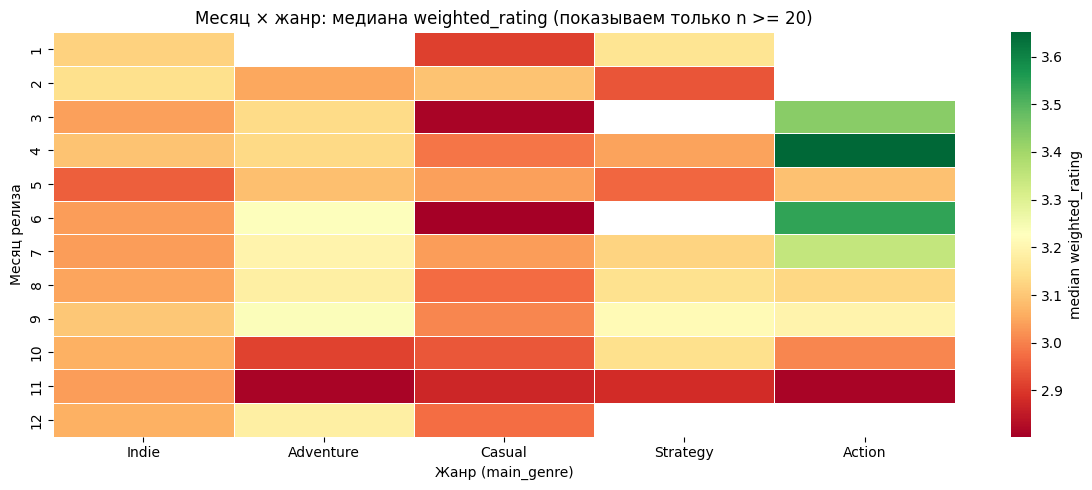

In [126]:
min_n = 20
top_genres = df["main_genre"].astype(str).value_counts().head(5).index

pt_med_genre = (df[df["main_genre"].astype(str).isin(top_genres)].pivot_table(index="release_month_clean", columns="main_genre", values="weighted_rating",
                 aggfunc="median")
    .reindex(index=months, columns=top_genres))

pt_n_genre = (df[df["main_genre"].astype(str).isin(top_genres)].pivot_table(index="release_month_clean", columns="main_genre", values="name",
                 aggfunc="size", fill_value=0)
    .reindex(index=months, columns=top_genres))

mask = pt_n_genre < min_n


plt.figure(figsize=(12,5))
sns.heatmap(
    pt_med_genre, mask=mask, cmap="RdYlGn",
    vmin=pt_med_genre.min().min(), vmax=pt_med_genre.max().max(),
    linewidths=0.5, linecolor="white",
    cbar_kws={"label":"median weighted_rating"})

plt.title(f"Месяц × жанр: медиана weighted_rating (показываем только n >= {min_n})")
plt.xlabel("Жанр (main_genre)")
plt.ylabel("Месяц релиза")
plt.tight_layout()
plt.show()

**Что можно заметить**

- Самое стабильное: Indie

По Indie почти нет пропусков, жанр часто встречается в каждом месяце и медианы довольно ровные (без резких скачков). Это значит, что по Indie сезонность по рейтингу, если и есть, то слабая

- Самое заметное: Action

У Action выделяются месяцы 3–4 и 6–7, а 11 месяц выглядит хуже (медиана ниже).
Практически: для Action есть намёк на удачные окна по качеству релизов, и отдельно видно, что ноябрь по качеству (weighted_rating) выглядит слабее в сравнении с другими месяцами

- Adventure/Casual — “плавающие”, но без экстремумов

У Adventure и Casual цветовая динамика есть, но в целом без огромных перепадов, сезонность умеренная, скорее чуть лучше/хуже, чем очень хорошо/очень плохо

- Strategy — не так много данных

По Strategy много белых клеток, значит жанр реже встречается, поэтому даже с фильтром видно, что покрытие слабое. Значит, про сезонность Strategy по этому датасету уверенно говорить сложно

**Вывод:**
После фильтрации (n >= 20) картина становится более честной:
ярко выраженной сезонности по всем жанрам сразу нет, но внутри отдельных жанров (особенно Action) есть месяцы, где медианный weighted_rating стабильно выше/ниже.
То есть сезонность тут скорее жанровая, а не общая по рынку

### 5. Теплокарта «месяц × возрастное ограничениме» по медианному weighted_rating

Проанализируем количество пересечений

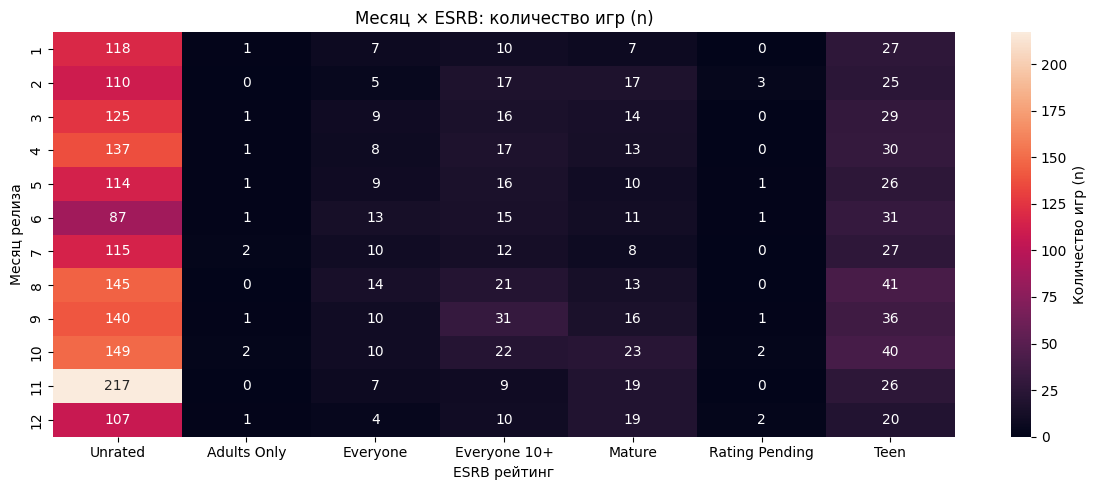

In [127]:
months = list(range(1, 13))

df_esrb = df.copy()
df_esrb["esrb_rating"] = df_esrb["esrb_rating"].astype(str).str.strip()
df_esrb.loc[df_esrb["esrb_rating"].isin(["nan", "None", "Unknown", "Not Rated"]), "esrb_rating"] = "Unrated"

order_esrb = ["E", "E10+", "T", "M", "AO", "RP", "Unrated"]
order_esrb = [x for x in order_esrb if x in df_esrb["esrb_rating"].unique()] + [x for x in sorted(df_esrb["esrb_rating"].unique()) if x not in order_esrb]

pt_n = (df_esrb.pivot_table(index="release_month_clean", columns="esrb_rating",
                            values="name", aggfunc="size", fill_value=0).reindex(index=months, columns=order_esrb))

plt.figure(figsize=(12, 5))
sns.heatmap(pt_n, annot=True, fmt="d", cbar_kws={"label": "Количество игр (n)"})
plt.title("Месяц × ESRB: количество игр (n)")
plt.xlabel("ESRB рейтинг")
plt.ylabel("Месяц релиза")
plt.tight_layout()
plt.show()

Видим, что здесь много пересечений по Unrated и мало по всем остальным, поэтому данный анализ не получится провести корректно

### 6. Теплокарта «месяц × платформы» по медианному weighted_rating

#### Рассмотрим количество пересечений

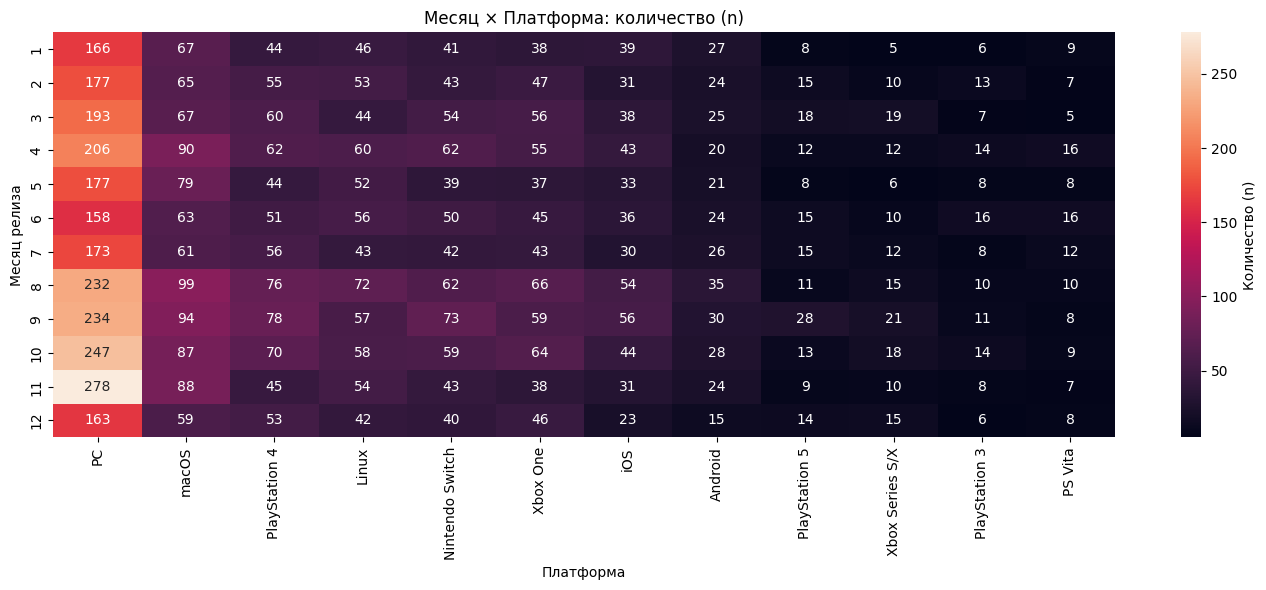

In [128]:
top_plt = 12

df_p = df.copy()

df_p["platform"] = df_p["platforms"].astype(str).str.split(r",\s*")
df_p = df_p.explode("platform")
df_p["platform"] = df_p["platform"].astype(str).str.strip()
df_p = df_p[df_p["platform"].notna() & (df_p["platform"] != "") & (df_p["platform"].str.lower() != "nan")]

top_plats = df_p["platform"].value_counts().head(top_plt).index

pt_n = (df_p[df_p["platform"].isin(top_plats)].pivot_table(index="release_month_clean", columns="platform", values="name",
                     aggfunc="size", fill_value=0).reindex(index=months, columns=top_plats))

plt.figure(figsize=(14, 6))
sns.heatmap(pt_n, annot=True, fmt="d", cbar_kws={"label": "Количество (n)"})
plt.title("Месяц × Платформа: количество (n)")
plt.xlabel("Платформа")
plt.ylabel("Месяц релиза")
plt.tight_layout()
plt.show()

- Основной объём данных сосредоточен на PC (в каждом месяце самые большие n), дальше идут macOS, PlayStation 4, Linux, Nintendo Switch, Xbox One, iOS, Android — по ним в большинстве месяцев выборка уже достаточно заметная

- PlayStation 5 / Xbox Series S|X / PlayStation 3 / PS Vita почти везде имеют очень маленькие n (часто единицы/десятки). Это означает, что любые скачки в метриках по этим платформам будут нестабильны и могут быть шумом

- В целом по количеству релизов/игр видно, что вторая половина года (особенно 8–11 месяцы) даёт больше наблюдений на ключевых платформах (PC и часть консолей) — значит сравнения по этим месяцам будут надежнее, чем там, где выборка минимальна

#### Month × Platform: медиана метрики с фильтром n >= 20

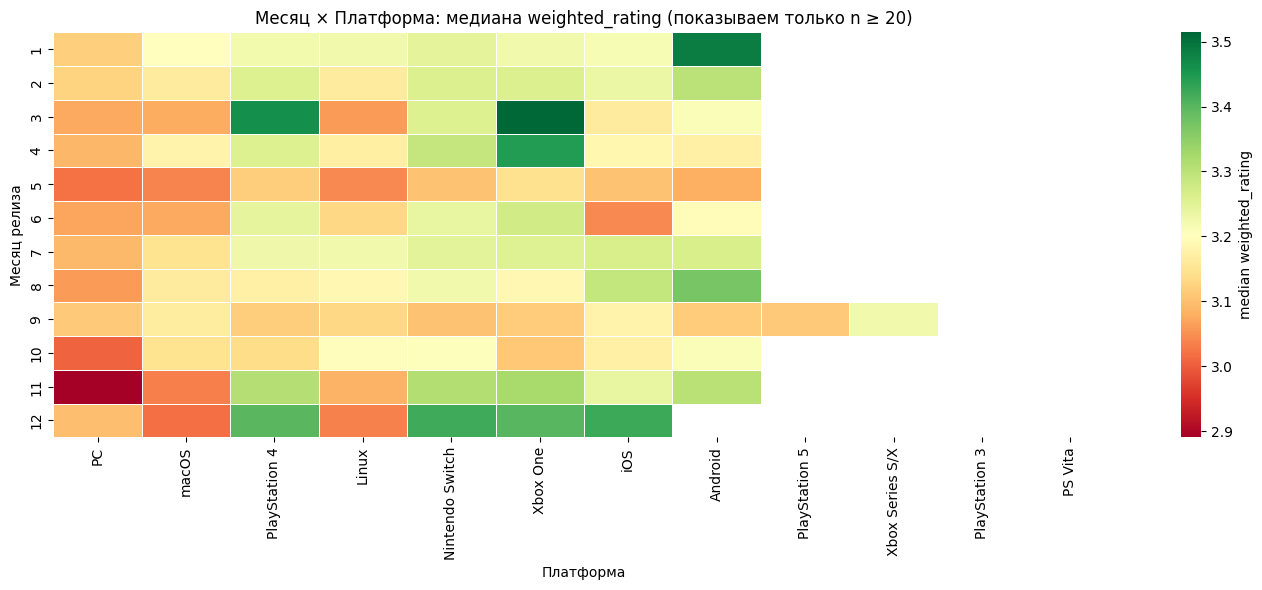

In [129]:
metric = "weighted_rating"
min_n = 20

pt_med = (df_p[df_p["platform"].isin(top_plats)]
          .pivot_table(index="release_month_clean", columns="platform", values=metric,aggfunc="median")
          .reindex(index=months, columns=top_plats))

pt_n2 = (df_p[df_p["platform"].isin(top_plats)]
         .pivot_table(index="release_month_clean", columns="platform", values=metric, aggfunc="size")
         .reindex(index=months, columns=top_plats))

mask = pt_n2 < min_n

plt.figure(figsize=(14, 6))
sns.heatmap(pt_med, mask=mask, cmap="RdYlGn", linewidths=.5, cbar_kws={"label": f"median {metric}"})
plt.title(f"Месяц × Платформа: медиана {metric} (показываем только n ≥ {min_n})")
plt.xlabel("Платформа")
plt.ylabel("Месяц релиза")
plt.tight_layout()
plt.show()

Фильтр n >= 20 делает картину более корректной: мы смотрим только те клетки “месяц × платформа”, где медиана действительно имеет смысл (а не строится на 3–10 играх)

- После фильтра видно, что различия по месяцам в рамках одной платформы в основном умеренные: нет ощущения, что месяц полностью “убивает” рейтинг на всех платформах — скорее есть локальные улучшения/просадки

- Также становится заметно, что платформы различаются между собой: у части платформ медианный weighted_rating чаще держится в “более зелёной” зоне, у части — ближе к “желто-оранжевой”


**Где лучше всего по разным платформам** (максимальная медиана weighted_rating)

- Android — январь (1 месяц)

- Xbox One — март (3 месяц)

- PlayStation 4 — март (3 месяц), также декабрь (12)

- Nintendo Switch — декабрь (12 месяц)

- iOS — декабрь (12 месяц)

## Анализ по всей работе, которуй мы делали в рамках нашей гипотезы

После всех графиков можно прийти к такому общему выводу:

Мы сначала увидели, что в разные месяцы показатели как будто сильно отличаются — где-то резкие провалы, где-то заметные пики. Но потом стало понятно, почему так происходит: многие наши метрики **накопительные** (added, ratings_count, suggestions_count). То есть чем старше игра, тем больше она успевает накопить добавлений и оценок и это естественно. Поэтому, если в каком-то месяце в датасете оказалось больше молодых игр, этот месяц будет выглядеть хуже не потому, что людям неинтересно, а просто потому, что у игр было меньше времени разогнаться

И вот тут очень важный момент: когда мы отдельно проверили **возраст игр по месяцам**, выяснилось, что в целом месяцы более-менее сопоставимы, **но ноябрь явно выбивается** — там игры заметно моложе. Из-за этого ноябрь и выглядел аномально плохим в накопительных метриках. То есть большая часть ноябрьского провала — это не сезонность, а эффект того, что игры просто недавно вышли

Чтобы это исправить и сравнивать честно, мы посмотрели **нормализованные метрики** (в формате *_per_day). И вот там картинка стала гораздо спокойнее: пропало ощущение, что есть катастрофически плохие месяцы и идеальные месяцы. Вместо этого видно более реалистичную штуку — **в одни месяцы темп набора интереса чуть выше, в другие чуть ниже**, но без драматических скачков. То есть сезонность есть, но она **умеренная**, и её легко переоценить, если смотреть только на накопленные значения

Дальше мы добавили ещё один слой смысла: посмотрели пересечения **месяц × жанр** и **месяц × платформа**. И тут стало очевидно, что одного лучшего месяца для всех не существует, но для отдельных категорий он прослеживается. В каких-то жанрах/на платформах один месяц выглядит лучше по рейтингу, в других — другой. Плюс мы специально ввели фильтр **n >= 20**, потому что если в ячейке мало игр, можно случайно сделать громкий вывод из пары удачных/неудачных релизов. С фильтром видно уже то, чему можно доверять

Ещё отдельно по графику количества релизов видно, что **осенью (примерно август–ноябрь) релизов больше**, то есть конкуренция выше. А в начале года и летом релизов меньше — конкуренция ниже. Но важно: это не означает автоматически, что осенью “лучше” или “хуже” выпускаться. Это означает, что осенью просто **теснее рынок**, и там сложнее выделиться, зато аудитория потенциально активная — и всё решает сегмент, возможности разработчиков на рекламу и качество игры

**Итог по лучшим месяцам:**

### 1) Какие месяцы в сумме выглядят наиболее перспективными

**Главный “победитель” по совокупности**

**4 месяц (апрель)** — самый стабильный кандидат, который чаще всего выплывает в разных разрезах и имеет хорошие результаты во всех анализах выше

Он одновременно:

* попадает в месяцы повышенного интереса
* имеет всплесплески интеерса по suggestion_count
* часто показывает неплохие значения по метрикам, одни из самых высоких
* имеет умеренную конкуренцию
* и при этом не выглядит как крайность (не “аномальный” месяц, где всё держится на перекосе данных)

**Сильные альтернативы (если не апрель)**

**3 и 9 месяцы (март и сентябрь)** — хорошие альтернативы:

* по рейтинговым метрикам/оценкам они выглядят успешно,
* плюс это удобные периоды с понятной активностью аудитории

---

### 2) Какие месяцы менее перспективные

Тут важно разделить “хуже по метрикам” и “сложнее из-за конкуренции”:

* **11 месяц (ноябрь)** стабильно выглядит слабее (по выводам он часто давал провал по оценкам/интересу)

  Практически: **релиз в ноябре рискованнее** — выше шанс недобрать внимания/оценок (или потребуется сильнее маркетинг)
* **5 месяц (май)** тоже чаще попадал в спад по части метрик интереса/оценок (и по промежуточным выводам)

---

### 3) Конкуренция по числу релизов (важно для стратегии)

По графику “число релизов по месяцам” логика такая:

* **8–10 месяцы** — **высокая конкуренция** (много релизов, поэтому сложнее сложнее выделиться)
* **6–7 и 12 месяцы** — конкуренция **ниже** (релизов меньше, из-за чего проще быть заметнее, подойдет для компаний, которые только начинаю разработку игр, мало известны и. имеют маленький бюджет на продвижение игры)

То есть:

* если у вас сильный продукт и маркетинг, можно идти в **пиковые месяцы интереса**, даже если там много конкурентов
* если бюджет/маркетинг ограничены, разумнее выбирать **месяцы с меньшей конкуренцией**, чтобы игра не утонула в конкуренции

---

### 4) Отдельно: рекомендация для жанра Action

По анализу выше: **Action лучше выпускать к 6–7 или к 4–3 месяцу**.

Переводим это в практику:

* **Если хотим максимум баланса:** **апрель (4)** или **март (3)** — хорошее сочетание интереса и качества отклика
* **Если хотим выделиться на фоне меньшей конкуренции:** **июнь–июль (6–7)** — более “спокойное поле”, где проще собрать внимание

---

### 5) Платформы тоже имеют сезонность

* **Android - 1 месяц (январь)**
* **Xbox One - 3 месяц (март)**
* **PS4 - 3 или 12 (март / декабрь)**
* **Nintendo Switch - 12 (декабрь)**
* **iOS - 12 (декабрь)**

**Практический смысл:** если игра выходит **не везде**, а на конкретной платформе — можно подстраивать релиз под “сильный” месяц именно этой платформы

---

###**Финальный общий вывод когда лучше выпускать игру**

Если выбрать месяцы, которые чаще всего выглядят перспективно **по сумме всех графиков**, то получится:

* **Лучшие универсальные месяцы:** **4** (главный), затем 3 и 9
* **Если цель — поймать всплеск интереса:** 2, 4, 7, 9, 10
* **Если цель — меньше конкуренции:** 6, 7, 12
* **Месяцы, где плохо идет развитие игр:** 11 (и частично 5)


## Вывод по гипотезе


**Гипотеза подтверждается**\

Видно, что месяц релиза действительно связан с тем, как игра набирает внимание/популярность (added, ratings, suggestions), и есть месяцы, где результаты чаще выше (например, 4, 7, 9–10), а есть более слабые (особенно 11).

## Бизнес-инсайты для команды разработчиков



1. **Планировать релизы по сильным месяцам, а не равномерно.**
   Если компания хочет максимум шансов на хороший старт, базовая рекомендация — целиться в **4 месяц** как самый стабильный “универсальный” вариант. В качестве альтернатив — **3 и 9**

2. **Разделять стратегию “лучший отклик” и “меньше конкуренции”.**

* Если есть сильный маркетинг и уверенность в продукте, то можно идти в месяцы повышенного интереса (**2, 4, 7, 9, 10**).
* Если маркетинг ограничен, то лучше выбирать месяцы с **меньшей конкуренцией** (**6–7 и 12**), чтобы не утонуть среди большого числа релизов

3. **Ноябрь (11) — месяц повышенного риска.**
   Он стабильно выглядит слабее по вовлечению/оценкам. Это не значит никогда не релизить, но значит:

* нужен сильнее маркетинг,
* либо лучше переносить релиз, если цель — быстрый рост рейтингов и отклика

4. **Жанровые и платформенные окна важны.**
   При анализе мы увидели, что лучшие месяцы могут отличаться по платформам (например, iOS/Switch — сильнее в 12, Xbox One — в 3, Android — в 1), так же и по жанрам

   Практически: **если релиз не мультиплатформенный**, или есть главная платформа — логично подбирать месяц под неё, а не по рынку в целом